## ewf-wfp-02-02-03 - Snow Cover Characterization Anomalies

Snow Cover Characterization Anomalies

---

### <a name="service">Service definition

In [4]:
service = dict([('title', 'Snow Cover Characterization Anomalies'),
                ('abstract', 'Snow Cover Characterization Anomalies'),
                ('id', 'ewf-wfp-02-02-03')])

### <a name="parameter">Parameter Definition 

In [5]:
#nameOfRegion = dict([('id', 'nameOfRegion'),
#                     ('value', 'CentralAsia'),
#                     ('title', 'Name of Region'),
#                     ('abstract', 'Name of the region of interest'),
#                     ('minOccurs', '1')])

In [24]:
indexAggCat = dict([('id', 'indexAggCat'),
             ('value', 'better-wfp-02-02-01'),
             ('title', 'indexAggCat'),
             ('abstract', 'index to access catalog of aggregated land surface temperature time series'),
             ('minOccurs', '1')])

In [25]:
apikeyAggCat = dict([('id', 'apikeyAggCat'),
                ('value', ''),
                ('title', 'apikeyAggCat'),
                ('abstract', 'apikey to access indexAggCat catalog'),
                ('minOccurs', '1')])

In [26]:
indexLtaCat = dict([('id', 'indexLtaCat'),
             ('value', 'better-wfp-02-02-02'),
             ('title', 'indexLtaCat'),
             ('abstract', 'index to access catalog of aggregated land surface temperature time series'),
             ('minOccurs', '1')])

In [27]:
apikeyLtaCat = dict([('id', 'apikeyLtaCat'),
                ('value', ''),
                ('title', 'apikeyLtaCat'),
                ('abstract', 'apikey to access indexAggCat catalog'),
                ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [48]:
# 2015, 2016, 2017
input_identifiers = ('B77070E553D873607FC364B65C0D4626BFACBB54', 'DB6B9CAF41855B025D2AE2AC9E95D30A03BA71D5')

#, 'LST_SouthernAfrica_N3_maxvalues_2015-01-01_2015-01-21.tif', 'LST_SouthernAfrica_N3_maxvalues_2016-01-01_2016-01-21.tif', 'LST_SouthernAfrica_N3_maxvalues_2017-01-01_2017-01-21.tif'



**Input references**

This is the MODIS stack catalogue references

In [49]:
input_references = ('https://catalog.terradue.com/better-wfp-02-02-01/search?uid={}'.format(input_identifiers[0]), 'https://catalog.terradue.com/better-wfp-02-02-02/search?uid={}'.format(input_identifiers[1])) 

**Data path**

This path defines where the data is staged-in. 

In [50]:
data_path = "/workspace/ewf-wfp-02-02-03/src/main/app-resources/notebook/libexec/data"

#### Aux folders

In [59]:
output_folder = ''

In [60]:
temp_folder = 'temp'

#### Import Modules

In [61]:
import os
import shutil

import cioppy
import datetime as dt

import pandas as pd
import geopandas as gpd

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import pdb
ciop = cioppy.Cioppy()

#### Auxiliary vars

In [62]:
check_results = False

#### Auxiliary methods

In [63]:
def get_input_metadata (input_refs):
    
    # for each product get metadata
    Result_Prod = []
    
    for index,product_ref in enumerate(input_refs):
        if 'LTA_' in product_ref:
            apikey = apikeyLtaCat
            indexCat = indexLtaCat
        else:
            apikey = apikeyAggCat
            indexCat = indexAggCat
        
        # since the search is by identifier 
        Result_Prod.append(ciop.search(end_point = product_ref,params =[],output_fields='self,identifier,startdate,enclosure,title,startdate,enddate,wkt',creds='{}:{}'.format(indexCat['value'],apikey['value']))[0] )
    

    input_metadata = gpd.GeoDataFrame.from_dict(Result_Prod)

    input_metadata['startdate'] = pd.to_datetime(input_metadata['startdate'])
    input_metadata['enddate'] = pd.to_datetime(input_metadata['enddate'])
    
    return input_metadata

def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e) 
    
def get_metadata(filepath):
        
    #pdb.set_trace()
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type


def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
        
        print(type(product_array))
    return mat_list


def calc_anomaly(agg_file, LTA_file):
    
    
    #file_list = []
    #if not os.path.isdir('tmp_data'):
    #    os.mkdir('tmp_data')
    #for enclosure in dataframe['enclosure'].tolist():
    #    filepath = 'tmp_data/' + os.path.basename(enclosure)
    #    status = get_product(enclosure, filepath)
    #    if status == 200:
    #        file_list.append(filepath)
    #print(file_list)
    
    
    
    if agg_file and LTA_file:
        
        
        agg_and_LTA = get_matrix_list([agg_file, LTA_file])
        print('Aggregation and LTA converted to matrices')
        
        print(agg_and_LTA[0].dtype)
        print(agg_and_LTA[1].dtype)
        
        #anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0)
        
        #anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0, out=np.zeros_like(agg_and_LTA[0] * 1.0), where=agg_and_LTA[1]!=0)
        
        anomaly_values = agg_and_LTA[0] - agg_and_LTA[1]
        #anomaly_values[(agg_and_LTA[0] == 0)] = 0
        #anomaly_values[(agg_and_LTA[1] == 0)] = 0
        
        print(anomaly_values.dtype)
        
        projection, geotransform, no_data_value, data_type = get_metadata(agg_file)
        
        
        
        #for file_ in file_list:
        #    os.remove(file_)
        
        return anomaly_values, projection, geotransform, no_data_value, data_type
    
    else:
        return None, None, None


def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    if mask is not None and mask is not 0:
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)

    

def write_anomaly_output(anomaly, output_folder, product_name, first_date, last_date, lta_start_year, lta_end_year, mask_no_value, roi_name, projection, geo_transform, no_data_value):
    #image_number = (datetime.strptime(last_date, '%Y-%m-%d') - datetime.strptime(first_date, '%Y-%m-%d')).days
    
    
    #filename =  output_folder + '/' + product_name + '_Anomaly_' + roi_name + '_N' + str(N_value) + '_' + aggregation + '_' + first_date + '_' + last_date + '_LTA' + str(lta_start_year) + '_' + str(lta_end_year) + '.tif'
    
    #snow_ndays_Anomaly_CentralAsia_2015-08-05_2016-07-27_LTA2015_2017.tif
    #Anomaly_SCNDays_CentralAsia_2015_2016_LTA_2015_2017.tif
    
    filename = os.path.join(output_folder, '_'.join(['Anomaly', product_name, roi_name, first_date.split('_')[0], last_date.split('_')[0], 'LTA', str(lta_start_year), str(lta_end_year)]) + '.tif')
    
    write_output_image(filename, anomaly, 'GTiff', gdal.GDT_Float32, mask_no_value, projection, geo_transform, no_data_value)
    return filename



#### Auxiliary folders

In [64]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

In [65]:
input_metadata = get_input_metadata(input_references)
#N = nv
print(input_metadata)

                                           enclosure    enddate  \
0  https://store.terradue.com/better-wfp-02-02-01... 2016-07-27   
1  https://store.terradue.com/better-wfp-02-02-02...        NaT   

                                 identifier  \
0  B77070E553D873607FC364B65C0D4626BFACBB54   
1  DB6B9CAF41855B025D2AE2AC9E95D30A03BA71D5   

                                                self  startdate  \
0  https://catalog.terradue.com/better-wfp-02-02-... 2015-08-05   
1  https://catalog.terradue.com/better-wfp-02-02-...        NaT   

                                        title  \
0  Output SCNDays_MTerra_h19v04_2015_2016.tif   
1     LTA_MTerra_SCNDays_h19v04_2015_2017.tif   

                                                 wkt  
0  POLYGON((12.9805303891434 39.8218653179575,15....  
1  POLYGON((15.5572382657578 39.9999999964109,26....  


#### Workflow

In [67]:
#print('hello')
#pdb.set_trace()
if isinstance(input_identifiers, str):
    input_identifiers = [input_identifiers]

#region_of_interest = regionOfInterest['value']
#name_of_region = nameOfRegion['value']

#filepath_agg = os.path.join(data_path, input_references[0].split('/')[-1])
#filepath_LTA = os.path.join(data_path, input_references[1].split('/')[-1])
enclosure = list(input_metadata['enclosure'])
filepath_agg = os.path.join(data_path, os.path.basename(enclosure[0]).split('?')[0]) 
filepath_LTA = os.path.join(data_path, os.path.basename(enclosure[1]).split('?')[0])




#filepath_agg = data_path + '/' + input_identifiers[0]
#filepath_LTA = data_path + '/' + input_identifiers[1]

# list of files
print(filepath_agg)
print(filepath_LTA)



# get metadata from filenames

file_name_elements = os.path.basename(filepath_agg).split('.')[0].split('_')
#['LST', 'SouthernAfrica', 'N3', 'averages', '2015-01-01', '2015-01-21']
#['snow', 'ndays', 'CentralAsia', '2015-08-05', '2016-07-27']
print(file_name_elements)



first_date = file_name_elements[-2]
last_date = file_name_elements[-1]
agg_type = '_'.join(file_name_elements[-5:-3])
name_of_region = file_name_elements[-3]
#Nn = file_name_elements[-4]


file_name_elements = os.path.basename(filepath_LTA).split('.')[0].split('_')
#['LTA', 'LST', 'SouthernAfrica', 'N3', 'averages', '1-1', '1-21', '2015', '2017']

lta_start_year = file_name_elements[-2]
lta_end_year = file_name_elements[-1]

prod_type = file_name_elements[-4]
#Nn_LTA = file_name_elements[-6]

#['LTA', 'snow', 'ndays', 'CentralAsia', '8-5', '7-27', '2015', '2017']


print(filepath_agg)
print(filepath_LTA)


anomaly_values, projection, geotransform, no_data_value, data_type = calc_anomaly(filepath_agg, filepath_LTA)


filename = write_anomaly_output(anomaly_values, output_folder, prod_type, first_date, last_date, lta_start_year, lta_end_year, None, name_of_region, projection, geotransform, no_data_value)




/workspace/ewf-wfp-02-02-03/src/main/app-resources/notebook/libexec/data/SCNDays_MTerra_h19v04_2015_2016.tif
/workspace/ewf-wfp-02-02-03/src/main/app-resources/notebook/libexec/data/LTA_MTerra_SCNDays_h19v04_2015_2017.tif
['SCNDays', 'MTerra', 'h19v04', '2015', '2016']
/workspace/ewf-wfp-02-02-03/src/main/app-resources/notebook/libexec/data/SCNDays_MTerra_h19v04_2015_2016.tif
/workspace/ewf-wfp-02-02-03/src/main/app-resources/notebook/libexec/data/LTA_MTerra_SCNDays_h19v04_2015_2017.tif
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
Aggregation and LTA converted to matrices
uint16
uint16
uint16


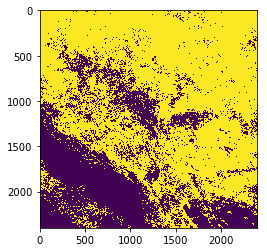

In [68]:
if check_results:

    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(anomaly_values)
    plt.show()

In [69]:
if check_results:

    import rasterio

    from rasterio.plot import show

    # Load data
    #raster = output_folder + '/' + 'LST_Anomaly_SouthernAfrica_N3_averages_2015-01-01_2015-01-21_LTA2015_2017.tif'
    raster = filename
    data = rasterio.open(raster)

    show(data)

    #data = georasters.from_file(raster)

    # Plot data
    #data.plot()

ImportError: No module named rasterio

#### Remove temporay files and folders

In [34]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)